In [45]:
import meshio
import torch
import numpy as np

mesh_first = meshio.read('/local/rmenezes/master_thesis/deep_sim/data/train/simulation_0/vtk/ParticleData_Fluid_1.vtk')
mesh_second = meshio.read('/local/rmenezes/master_thesis/deep_sim/data/train/simulation_0/vtk/ParticleData_Fluid_2.vtk')
mesh_last = meshio.read('/local/rmenezes/master_thesis/deep_sim/data/train/simulation_0/vtk/ParticleData_Fluid_1553.vtk')

In [65]:
points = mesh_first.points
ids = mesh_first.point_data['id']

In [75]:
ids = mesh_first.point_data['id']
sorted_index = np.argsort(np.squeeze(ids))
sorted_points = mesh_first.points[sorted_index]
xy_coordinates = sorted_points[:, :2].astype('float32')
torch.tensor(xy_coordinates, dtype=torch.float)

tensor([[1.9005, 0.7186],
        [1.9005, 0.7546],
        [1.9005, 0.7906],
        ...,
        [2.8365, 1.5826],
        [2.8365, 1.6186],
        [2.8365, 1.6546]])

In [73]:
points[np.argsort(np.squeeze(ids))]

array([[1.900492  , 0.7186018 , 0.        ],
       [1.900492  , 0.75460184, 0.        ],
       [1.900492  , 0.7906018 , 0.        ],
       ...,
       [2.836492  , 1.5826018 , 0.        ],
       [2.836492  , 1.6186018 , 0.        ],
       [2.836492  , 1.6546018 , 0.        ]], dtype='>f4')

In [51]:
mesh_first.points

array([[1.900492  , 0.7186018 , 0.        ],
       [1.936492  , 0.7186018 , 0.        ],
       [1.900492  , 0.75460184, 0.        ],
       ...,
       [2.836492  , 1.5826018 , 0.        ],
       [2.836492  , 1.6186018 , 0.        ],
       [2.836492  , 1.6546018 , 0.        ]], dtype='>f4')

In [61]:
mesh_first.points[[0,4]]

array([[1.900492 , 0.7186018, 0.       ],
       [1.936492 , 0.7906018, 0.       ]], dtype='>f4')

In [8]:
mesh_first.points[mesh_first.point_data['id']]

array([[[1.900492 , 0.7186018, 0.       ]],

       [[1.972492 , 0.8626018, 0.       ]],

       [[1.936492 , 0.7186018, 0.       ]],

       ...,

       [[2.836492 , 1.5826018, 0.       ]],

       [[2.836492 , 1.6186018, 0.       ]],

       [[2.836492 , 1.6546018, 0.       ]]], dtype='>f4')

In [22]:
mesh_second.point_data['id'][1]

array([27], dtype='>u4')

In [14]:
mesh_first.points[0]

array([1.900492 , 0.7186018, 0.       ], dtype='>f4')

In [18]:
mesh_second.points[0]

array([1.900492 , 0.7183075, 0.       ], dtype='>f4')

In [11]:
from data_reader import SimulationDataset
from learned_simulator import Simulator
import json
import torch
import lightning as L
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from matplotlib import animation
import matplotlib.pyplot as plt
import os
import meshio

INPUT_SEQUENCE_LENGTH = 6
DEVICE = 'cpu'
MODE = 'train'
STRATEGY = 'baseline'
noise_std = 6.7e-4

ds = SimulationDataset(device=DEVICE, mode='train', window_size=6, load_max=5)

# with open('metadata.json', 'rb') as f:
#     metadata = json.load(f)

# num_steps = metadata['sequence_length'] - INPUT_SEQUENCE_LENGTH

In [12]:
ds.file_metadata

[('data/train/simulation_311/vtk',
  ['ParticleData_Fluid_1.vtk',
   'ParticleData_Fluid_2.vtk',
   'ParticleData_Fluid_3.vtk',
   'ParticleData_Fluid_4.vtk',
   'ParticleData_Fluid_5.vtk',
   'ParticleData_Fluid_6.vtk',
   'ParticleData_Fluid_7.vtk']),
 ('data/train/simulation_311/vtk',
  ['ParticleData_Fluid_2.vtk',
   'ParticleData_Fluid_3.vtk',
   'ParticleData_Fluid_4.vtk',
   'ParticleData_Fluid_5.vtk',
   'ParticleData_Fluid_6.vtk',
   'ParticleData_Fluid_7.vtk',
   'ParticleData_Fluid_8.vtk']),
 ('data/train/simulation_311/vtk',
  ['ParticleData_Fluid_3.vtk',
   'ParticleData_Fluid_4.vtk',
   'ParticleData_Fluid_5.vtk',
   'ParticleData_Fluid_6.vtk',
   'ParticleData_Fluid_7.vtk',
   'ParticleData_Fluid_8.vtk',
   'ParticleData_Fluid_9.vtk']),
 ('data/train/simulation_311/vtk',
  ['ParticleData_Fluid_4.vtk',
   'ParticleData_Fluid_5.vtk',
   'ParticleData_Fluid_6.vtk',
   'ParticleData_Fluid_7.vtk',
   'ParticleData_Fluid_8.vtk',
   'ParticleData_Fluid_9.vtk',
   'ParticleData_

In [7]:
data_dir = os.path.join('data', MODE)

def extract_number(filename):
    return int(filename.split('_')[-1].split('.')[0])

total_vel_sum = torch.zeros(2)
total_vel_sum_squared = torch.zeros(2) 
total_acc_sum = torch.zeros(2) 
total_acc_sum_squared = torch.zeros(2) 
velocity_count = 0
acceleration_count = 0

for sim_folder in tqdm(os.listdir(data_dir)):
    sub_data_dir = os.path.join(data_dir, sim_folder, 'vtk')
    mesh_files = sorted([f for f in os.listdir(sub_data_dir) if f.endswith('.vtk')], key=extract_number)

    all_positions = []
    if len(mesh_files) == 0: continue
    for mesh_file in mesh_files:
        mesh = meshio.read(os.path.join(sub_data_dir, mesh_file))
        xy_coordinates = mesh.points[:, :2].astype('float32')
        positions = torch.tensor(xy_coordinates, dtype=torch.float)
        all_positions.append(positions)
    
    all_positions = torch.stack(all_positions, dim=1) 
    all_velocities = all_positions[:, 1:, :] - all_positions[:, :-1, :]
    all_accelerations = all_velocities[:, 1:, :] - all_velocities[:, :-1, :]

    total_vel_sum += all_velocities.sum(dim=(0,1))
    total_acc_sum += all_accelerations.sum(dim=(0,1))
    total_vel_sum_squared += all_velocities.pow(2).sum(dim=(0,1))
    total_acc_sum_squared += all_accelerations.pow(2).sum(dim=(0,1))

    velocity_count += all_velocities.shape[0] * all_velocities.shape[1]
    acceleration_count += all_accelerations.shape[0] * all_accelerations.shape[1]
    
    
expected_velocity = total_vel_sum / velocity_count
expected_squared_velocity = total_vel_sum_squared / velocity_count

expected_acceleration = total_acc_sum / acceleration_count
expected_squared_acceleration = total_acc_sum_squared / acceleration_count

velocity_std = np.sqrt(expected_squared_velocity - expected_velocity.pow(2))
acceleration_std = np.sqrt(expected_squared_acceleration - expected_acceleration.pow(2))
print(expected_velocity)
print(expected_acceleration)
print(velocity_std)
print(acceleration_std)

100%|██████████| 640/640 [07:09<00:00,  1.49it/s]

tensor([ 1.2292e-05, -8.5227e-04])
tensor([-7.7658e-09,  2.2058e-07])
tensor([0.0677, 0.0327])
tensor([0.0956, 0.0459])


In [6]:
initial_positions = ds[0][0]
current_positions = initial_positions

for features, labels in ds:
    
    labels = labels.unsqueeze(1)  # Now labels shape is [361, 1, 2]
    
    current_positions = torch.cat((current_positions, labels), dim=1) 


print(current_positions.shape)

torch.Size([729, 1544, 2])


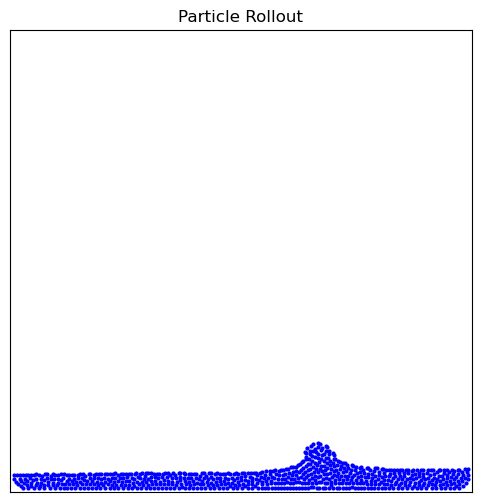

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Convert the tensor to a NumPy array for easier manipulation
trajectory = current_positions.numpy()

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Particle Rollout")
ax.set_xlim(0.0, 4.0)  # Set these based on your data's bounds
ax.set_ylim(0.0, 4.0)  # Adjust accordingly
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

# Initialize the points for plotting
points, = ax.plot([], [], "o", ms=2, color='blue')

# Number of steps in the trajectory
num_steps = trajectory.shape[1]

def update(step_i):
    # Update the data for the plot
    points.set_data(trajectory[:, step_i, 0], trajectory[:, step_i, 1])
    return points,

# Create the animation
step_stride = 6  # Increase this number to skip more frames and speed up the animation
ani = animation.FuncAnimation(
    fig, update,
    frames=np.arange(0, num_steps, step_stride), interval=10, blit=True
)

# Save or display the animation
# Uncomment the line below if you want to save as a GIF
ani.save('particle_rollout.gif', writer='pillow')



In [9]:

print(initial_positions.shape)

torch.Size([361, 6, 2])


In [8]:
metadata = {}
# Assuming 2 dimensions (x and y)
total_vel_sum = torch.zeros(2)  
total_acc_sum = torch.zeros(2)  
total_vel_count = 0
total_acc_count = 0

# For standard deviation calculations
vel_list_x = []
vel_list_y = []
acc_list_x = []
acc_list_y = []

samples = 0
# Iterate over the dataset
for features, labels in tqdm(ds):
    samples += 1
    vel_sequence = features[:, 1:] - features[:, :-1]
    acc_sequence = vel_sequence[:, 1:] - vel_sequence[:, :-1]
    
    # Calculate means
    total_vel_sum += torch.sum(vel_sequence, dim=(0, 1))
    total_acc_sum += torch.sum(acc_sequence, dim=(0, 1))
    total_vel_count += vel_sequence.numel()  # Only count the values in the velocity sequence
    total_acc_count += acc_sequence.numel()
    
    # Store velocity and acceleration sequences for standard deviation calculation
    vel_list_x.append(vel_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
    vel_list_y.append(vel_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation
    acc_list_x.append(acc_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
    acc_list_y.append(acc_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation

# Compute means
mean_velocity = np.float64(total_vel_sum / total_vel_count)
mean_acceleration = np.float64(total_acc_sum / total_acc_count)

# Calculate standard deviations
vel_tensor = torch.stack([torch.cat(vel_list_x), torch.cat(vel_list_y)])
acc_tensor = torch.stack([torch.cat(acc_list_x), torch.cat(acc_list_y)])


std_velocity = np.float64(torch.std(vel_tensor, dim=1, unbiased=False))
std_acceleration = np.float64(torch.std(acc_tensor, dim=1, unbiased=False))

metadata['vel_mean'] = list(mean_velocity)
metadata['acc_mean'] = list(mean_acceleration)
metadata['vel_std'] = list(std_velocity)
metadata['acc_std'] = list(std_acceleration)
metadata['bounds'] = [[-2.0, 2.0], [0.0, 4.0]]
metadata['sequence_length'] = len(ds)
metadata['default_connectivity_radius'] = 0.12
metadata['dim'] = 2
metadata['dt'] = 0.0025
metadata['total_samples'] = samples

100%|██████████| 1388/1388 [00:03<00:00, 395.30it/s]


In [65]:
metadata

{'vel_mean': [-0.00016299991693813354, -0.00030746933771297336],
 'acc_mean': [3.293173733709409e-07, 2.3222348488616262e-07],
 'vel_std': [0.05058624595403671, 0.05058625712990761],
 'acc_std': [0.0713871493935585, 0.0713871493935585],
 'bounds': [[-2.0, 2.0], [0.0, 4.0]],
 'sequence_length': 1388,
 'default_connectivity_radius': 0.12,
 'dim': 2,
 'dt': 0.0025,
 'total_samples': 1388}

In [87]:
metadata = {}

initial_vel = torch.zeros(2)
initial_vel_var = torch.zeros(2)
initial_acc = torch.zeros(2)
initial_acc_var = torch.zeros(2)

for features, labels in ds:
    vel_sequence = features[:, 1:] - features[:, :-1]
    acc_sequence = vel_sequence[:, 1:] - vel_sequence[:, :-1]
    initial_vel = torch.mean(vel_sequence[:, :4], dim=(0,1))
    initial_acc = torch.mean(acc_sequence[:, :3], dim=(0,1))
    break

k = 0
prior_vel = initial_vel
prior_acc = initial_acc
for features, labels in ds:
    k += 1
    vel_sequence = (features[:, 1:] - features[:, :-1])
    most_recent_vel = vel_sequence[:, -1]
    most_recent_vel = torch.mean(most_recent_vel, dim=0)
    vel_correction = (most_recent_vel - prior_vel)
    prior_vel += vel_correction/k
    initial_vel_var += vel_correction * (most_recent_vel - prior_vel)

    most_recent_acc = (vel_sequence[:, 1:] - vel_sequence[:, :-1])[:, -1]
    most_recent_acc = torch.mean(most_recent_acc, dim=0)
    acc_correction = (most_recent_acc - prior_acc)
    prior_acc += acc_correction/k
    initial_acc_var += acc_correction * (most_recent_acc - prior_acc)


metadata['vel_mean'] = list(np.float64(prior_vel))
metadata['acc_mean'] = list(np.float64(prior_acc))
metadata['vel_std'] = list(np.float64(np.sqrt(initial_vel_var/k)))
metadata['acc_std'] = list(np.float64(np.sqrt(initial_acc_var/k)))
metadata['bounds'] = [[-2.0, 2.0], [0.0, 4.0]]
metadata['sequence_length'] = len(ds)
metadata['default_connectivity_radius'] = 0.1
metadata['dim'] = 2
metadata['dt'] = 0.0025
metadata['total_samples'] = k




with open('new_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [52]:
metadata = {}
# Assuming 2 dimensions (x and y)
total_vel_sum = torch.zeros(2)  
total_acc_sum = torch.zeros(2)  
total_vel_count = 0
total_acc_count = 0

# For standard deviation calculations
vel_list_x = []
vel_list_y = []
acc_list_x = []
acc_list_y = []

samples = 0
# Iterate over the dataset
for features, labels in tqdm(ds):
    samples += 1
    vel_sequence = features[:, 1:] - features[:, :-1]
    acc_sequence = vel_sequence[:, 1:] - vel_sequence[:, :-1]
    
    # Calculate means
    total_vel_sum += torch.sum(vel_sequence, dim=(0, 1))
    total_acc_sum += torch.sum(acc_sequence, dim=(0, 1))
    total_vel_count += vel_sequence.numel()  # Only count the values in the velocity sequence
    total_acc_count += acc_sequence.numel()
    
    # Store velocity and acceleration sequences for standard deviation calculation
    vel_list_x.append(vel_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
    vel_list_y.append(vel_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation
    acc_list_x.append(acc_sequence[:, 0].reshape(-1))  # Flatten x dimension to 1D tensor for std calculation
    acc_list_y.append(acc_sequence[:, 1].reshape(-1))  # Flatten y dimension to 1D tensor for std calculation

# Compute means
mean_velocity = np.float64(total_vel_sum / total_vel_count)
mean_acceleration = np.float64(total_acc_sum / total_acc_count)

# Calculate standard deviations
vel_tensor = torch.stack([torch.cat(vel_list_x), torch.cat(vel_list_y)])
acc_tensor = torch.stack([torch.cat(acc_list_x), torch.cat(acc_list_y)])


std_velocity = np.float64(torch.std(vel_tensor, dim=1, unbiased=False))
std_acceleration = np.float64(torch.std(acc_tensor, dim=1, unbiased=False))

metadata['vel_mean'] = list(mean_velocity)
metadata['acc_mean'] = list(mean_acceleration)
metadata['vel_std'] = list(std_velocity)
metadata['acc_std'] = list(std_acceleration)
metadata['bounds'] = [[-2.0, 2.0], [0.0, 4.0]]
metadata['sequence_length'] = len(ds)
metadata['default_connectivity_radius'] = 0.12
metadata['dim'] = 2
metadata['dt'] = 0.0025
metadata['total_samples'] = samples

100%|██████████| 1388/1388 [00:02<00:00, 530.53it/s]


In [4]:
with open('new_metadata.json', 'rb') as f:
    metadata = json.load(f)

simulator = Simulator(
    particle_dimension=2,
    node_in=30,
    edge_in=3,
    latent_dim=128,
    num_message_passing_steps=10,
    mlp_num_layers=2,
    mlp_hidden_dim=128,
    num_particle_types=9,
    particle_type_embedding_size=16,
    metadata=metadata,
    mode=MODE,
    strategy=STRATEGY,
    device=DEVICE,
)

from model_utils import get_random_walk_noise_for_position_sequence
step = 0
running_loss = 0.0
for features, labels in ds:
    step += 1

    num_particles, window_size, pos_dim = features.shape

    n_particles_per_example = [num_particles for _ in range(1)]
    
    position_sequence = features.view(-1, window_size, pos_dim)
    next_position = labels.view(-1, pos_dim)
    particle_types = torch.full((position_sequence.shape[0],), 5).to(DEVICE)
    sampled_noise = get_random_walk_noise_for_position_sequence(position_sequence, noise_std_last_step=noise_std).to(DEVICE)
    non_kinematic_mask = (particle_types != 3).clone().detach().to(DEVICE)
    # features['position'] = torch.tensor(features['position']).to(device)
    # features['n_particles_per_example'] = torch.tensor(features['n_particles_per_example']).to(device)
    # features['particle_type'] = torch.tensor(features['particle_type']).to(device)
    # labels = torch.tensor(labels).to(device)
    # sampled_noise = get_random_walk_noise_for_position_sequence(features['position'], noise_std_last_step=noise_std).to(device)
    # non_kinematic_mask = (features['particle_type'] != 3).clone().detach().to(device)
    sampled_noise *= non_kinematic_mask.reshape(-1, 1, 1)

    # pred, target = simulator.get_predicted_and_target_normalized_accelerations(
    #     next_position=labels, 
    #     position_sequence_noise=sampled_noise, 
    #     position_sequence=features['position'], 
    #     n_particles_per_example=features['n_particles_per_example'], 
    #     particle_types=features['particle_type'],
    # )
    input_graph, _, _, _ = simulator._encoder_preprocessor(
        position_sequence, 
        n_particles_per_example, 
        particle_types,
    )

    degrees = torch.bincount(input_graph.edge_index[0])

    # Step 2: Calculate the average degree
    average_neighbors = degrees.float().mean().item()
    print(average_neighbors)
    
print(step)

19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260253906
19.397804260

In [4]:
input_graph

Data(x=[361, 30], edge_index=[2, 6765], edge_attr=[6765, 3])

In [14]:
train_loader = DataLoader(ds, batch_size=2, shuffle=True, num_workers=0)

for position_sequence, next_position in train_loader:
    n_particles_per_example = [position_sequence.shape[1] for _ in range(2)]
    batch_size, num_particles, window_size, pos_dim = position_sequence.shape
    position_sequence = position_sequence.view(-1, window_size, pos_dim)  # shape: (batch_size * num_particles, window_size, pos_dim)
    next_position = next_position.view(-1, pos_dim)

    particle_types = torch.full((position_sequence.shape[0],), 5)


    noisy_position_sequence = position_sequence 
    print(torch.cat([torch.LongTensor([i for _ in range(n)]) for i, n in enumerate(n_particles_per_example)]))
    
    break

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
noisy_position_sequence.shape

torch.Size([722, 6, 2])

In [2]:
torch.cat([torch.LongTensor([i for _ in range(n)]) for i, n in enumerate(100)])

TypeError: 'int' object is not iterable

In [11]:
dataloader = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0)

In [13]:
dataloader

TypeError: 'DataLoader' object is not subscriptable

In [2]:
checkpoint_path = "lightning_logs/version_16/checkpoints/epoch=0-step=10.ckpt"
simulator = Simulator.load_from_checkpoint(
    checkpoint_path,
    particle_dimension=2,
    node_in=30,
    edge_in=3,
    latent_dim=128,
    num_message_passing_steps=10,
    mlp_num_layers=2,
    mlp_hidden_dim=128,
    num_particle_types=9,
    particle_type_embedding_size=16,
    metadata=metadata,
    strategy='baseline',
    device='cpu',
    )

In [3]:
def eval_single_rollout(simulator, features, num_steps, device):
    initial_positions = features[:, 0:INPUT_SEQUENCE_LENGTH]
    ground_truth_positions = features[:, INPUT_SEQUENCE_LENGTH:]
    
    current_positions = initial_positions
    predictions = []
    for step in range(num_steps):
        next_position = simulator.predict_positions(
            current_positions,
            n_particles_per_example=features['n_particles_per_example'],
            particle_types=features['particle_type'],
        ) # (n_nodes, 2)
        # Update kinematic particles from prescribed trajectory.
        kinematic_mask = (features['particle_type'] == 3).clone().detach().to(device)
        next_position_ground_truth = ground_truth_positions[:, step]
        kinematic_mask = kinematic_mask.bool()[:, None].expand(-1, 2)
        next_position = torch.where(kinematic_mask, next_position_ground_truth, next_position)
        predictions.append(next_position)
        current_positions = torch.cat([current_positions[:, 1:], next_position[:, None, :]], dim=1)
    predictions = torch.stack(predictions) # (time, n_nodes, 2)
    ground_truth_positions = ground_truth_positions.permute(1,0,2)
    loss = (predictions - ground_truth_positions) ** 2
    output_dict = {
        'initial_positions': initial_positions.permute(1,0,2).cpu().numpy(),
        'predicted_rollout': predictions.cpu().numpy(),
        'ground_truth_rollout': ground_truth_positions.cpu().numpy(),
        'particle_types': features['particle_type'].cpu().numpy(),
    }
    return output_dict, loss

In [19]:
for batch in dataloader:
    print(batch[0][0].shape)

torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361, 6, 2])
torch.Size([361,

In [4]:
initial_positions = ds[0][0]
current_positions = initial_positions
ground_truth_rollout = []
predictions = []

for features, labels in ds:
    # particle types are not really being used, only if we had obstacles
    particle_types = torch.full((current_positions.shape[0],), 5).to(DEVICE)
    
    next_position = simulator.predict_positions(
        current_positions,
        None,
        particle_types
    )

    ground_truth_rollout.append(labels)
    predictions.append(next_position)
    current_positions = torch.cat([current_positions[:, 1:], next_position[:, None, :]], dim=1)

ground_truth_rollout = torch.stack(ground_truth_rollout)
predictions = torch.stack(predictions)

loss = (predictions - ground_truth_rollout) ** 2

output_dict = {
    'initial_positions': initial_positions.permute(1,0,2).cpu().numpy(),
    'predicted_rollout': predictions.detach().cpu().numpy(),
    'ground_truth_rollout': ground_truth_rollout.cpu().numpy(),
    'particle_types': particle_types.cpu().numpy(),
}

In [5]:
output_dict['predicted_rollout']

array([[[-2.14397341e-01,  2.73891211e-01],
        [-2.31300890e-01,  1.91038370e-01],
        [-2.93496013e-01,  2.16028988e-01],
        ...,
        [-3.56864959e-01,  7.95827061e-02],
        [-3.66994709e-01,  1.11651555e-01],
        [-4.04841244e-01,  1.17947906e-01]],

       [[-9.79604483e-01,  4.40633744e-01],
        [-1.01433802e+00,  3.42324913e-01],
        [-1.11640990e+00,  3.49762022e-01],
        ...,
        [-1.34542835e+00,  6.76926374e-02],
        [-1.35611188e+00,  1.09357968e-01],
        [-1.44290733e+00,  9.40192938e-02]],

       [[-2.03335166e+00,  7.68786788e-01],
        [-2.09021473e+00,  6.14206851e-01],
        [-2.24051046e+00,  4.96877372e-01],
        ...,
        [-2.65527773e+00,  2.06629738e-01],
        [-2.66239643e+00,  2.30335474e-01],
        [-2.71944737e+00,  2.42481574e-01]],

       ...,

       [[-3.15984656e+05,  3.85122227e+04],
        [-3.16300875e+05,  3.75309453e+04],
        [-3.16256312e+05,  3.75168516e+04],
        ...,
     